In [1]:
import random
import math
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from scipy.optimize import minimize
from scipy.stats import gamma, norm
import seaborn as sns
import time

from functools import partial

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
N = int(1e5)  # MC iterations
def _r(x): return np.round(x, 2)
def _CI(mu, std, n=1, z=1): return mu + (z/np.sqrt(n)) * np.array([-std, std])

# Gaussian Modeling

## Guassian Random Vectors

The goal is to generate multi-variate normal random vectors. Consider $d=2$.
$$W = N(\mu, C)$$
We reduce to identity, i.e. $C = I$ and thus have independent rvs with zero covariance. Then, we can write W as:
$$W = \mu + BZ$$
where $Z = N(0,I)$. Note that we would be essentially generating:
$$W = N(\mu, BIB^T) = N(\mu, BB^T)$$
so we need to find $B$ s.t. $BB^T = C$. \\
With that form, $B$ is the *square root* of $C$.
Among the set of possible *square root* of $C$, we pick the **lower triangular**. We can find it through the **Cholesky factorization** of $C$. 


### Step 1
We need a way to simulate pairs of standard normals. \\
If we consider the joint density $f(Z_1, Z_2)$ we notice that presents **radial symmetry** which means that there is no angular preference. \\
Thus, denoting the angle by $\theta$ we have that its density is uniform on $[0, 2 \pi]$. \\
Moreover, if we consider the point in 2-D denoted by $(Z_1, Z_2)$, we see that we can write:
$$Z_1 = R \cdot cos\theta$$
$$Z_2 = R \cdot sin\theta$$
where $R^2 = Z_1^2 + Z_2^2$ \\
We proceed by noticing that the sum of two standard normals is chi-squared distributed with 2 degrees of freedom which in turn is exponetially distributed with mean 2 ($\lambda = 0.5$). 
The good news is that we know how to generate exponetials rvs through inverse sampling. The inverse CDF of an exponential is:
$$F^{-1} = \frac{-ln(U)}{\lambda}$$
For each $Z_1, Z_2$ simulation, we generate two uniforms (one for $R$ one for $\theta$) and then we plug-in the formulas described above obtaining the 2-d multivariate gaussian.

In [3]:
def generate_bivariate_gaussian():
  U_1, U_2 = np.random.uniform(), np.random.uniform()
  R = np.sqrt(-2*np.log(U_1))
  theta = 2*math.pi*U_2
  return R*np.cos(theta), R*np.sin(theta)

N = int(1e6)
Z = np.zeros((N,2))
for i in range(N):
  Z[i,:] = generate_bivariate_gaussian()

In [4]:
print('Mean:', _r(np.mean(Z, axis=0)))
print('Variance:', _r(np.var(Z, axis=0)))

Mean: [0. 0.]
Variance: [1. 1.]


###Step 2
Now that we have $Z$, we only need to find $L$ from the Cholesky decomposition and add $\mu$. \\
For instance, say we have a problem in which the $W$ follows a multivariate normal distribution with mean $\mu = [2,3]$ and variance $C = [[2, 0.5], [0.5, 1]]$, i.e. $Var(W_1)=2$, $Var(W_2)=1$, $Cov(W_1,W_2)=0.5$ \\
After derivation, we can write $L$ as:
$$L = [[\sigma_1, 0],[a, b]]$$
with $a = \rho \sigma_2$ and $b = \sigma_2 \sqrt{1 - \rho^2}$.

In [5]:
# Multivariate normal parameters
mu = np.array([2, 3])
C = np.array([[2, 0.5],
              [0.5, 1]])
sigma_1 = np.sqrt(C[0][0])
sigma_2 = np.sqrt(C[1][1])
rho = C[0][1] / (sigma_1 * sigma_2)

# Setting up Cholesky lower triangular
a = rho * sigma_2
b = sigma_2 * np.sqrt(1-rho**2)
L = np.array([[sigma_1, 0],
              [a, b]])

# Applying transformation and computing W
W = np.zeros((N,2))
for i in range(N):
  W[i,:] = mu + L @ Z[i,:]

print('Mean:', _r(np.mean(W, axis=0)))
print('Variance:', _r(np.var(W, axis=0)))

Mean: [2. 3.]
Variance: [2. 1.]


That's pretty cool!

## Euler–Maruyama method and uses it to solve the Ornstein–Uhlenbeck process

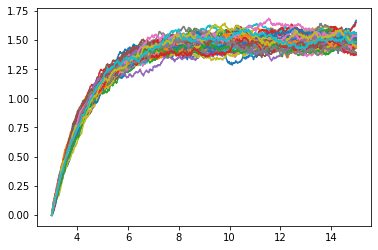

In [6]:
num_sims = 50  # Display five runs

t_init = 3
t_end  = 15
N      = 1000  # Compute 1000 grid points
dt     = float(t_end - t_init) / N
y_init = 0

c_theta = 0.7
c_mu    = 1.5
c_sigma = 0.06

def mu(y, t):
    """Implement the Ornstein–Uhlenbeck mu."""  # = \theta (\mu-Y_t)
    return c_theta * (c_mu - y)

def sigma(y, t):
    """Implement the Ornstein–Uhlenbeck sigma."""  # = \sigma
    return c_sigma

def dW(delta_t):
    """Sample a random number at each call."""
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

ts    = np.arange(t_init, t_end, dt)
ys    = np.zeros(N)

ys[0] = y_init

for _ in range(num_sims):
    for i in range(1, ts.size):
        t = (i-1) * dt
        y = ys[i-1]
        ys[i] = y + mu(y, t) * dt + sigma(y, t) * dW(dt)
    plt.plot(ts, ys)

plt.show()